In [460]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from fireTS.models import NARX
from sklearn.neural_network import MLPRegressor

plt.style.use('ggplot')

%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

### Задание 1

In [189]:
df = pd.read_csv('../SN_m_tot_V2.0.csv', sep=';', header=None)

In [190]:
var_date = '1777-07-01'

In [191]:
df = df.iloc[:, 0:4]
df = df.drop([2], axis=1)
df.columns = ['Year', 'Month', 'Value']
df.Year = df.Year.astype(str)
df.Month = df.Month.astype(str)
df.index = pd.to_datetime(df.Year + '-' + df.Month)
df.drop(['Year'], axis=1, inplace=True)
df.drop(['Month'], axis=1, inplace=True)

In [192]:
df.sample(5)

,Value
1900-02-01,22.8
1973-02-01,60.9
1850-09-01,163.7
1940-06-01,139.8
1976-06-01,17.9


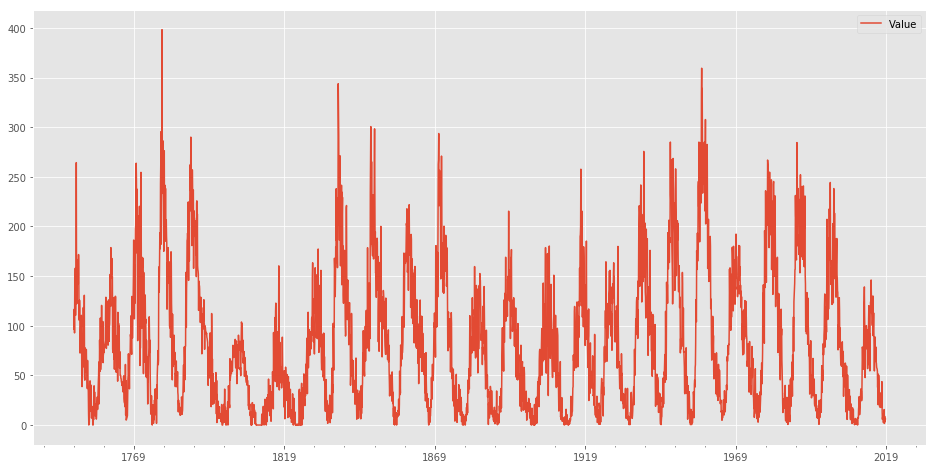

In [193]:
df.plot();

In [194]:
def strided_app(a, L, S ):  # Window len = L, Stride len/stepsize = S
    nrows = ((a.size-L)//S)+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,L), strides=(S*n,n))

kek = np.mean(strided_app(df.values, 12, 1), axis=1)

In [195]:
shift = df.shape[0] - kek.shape[0]
df.iloc[shift:] = kek[:, np.newaxis]

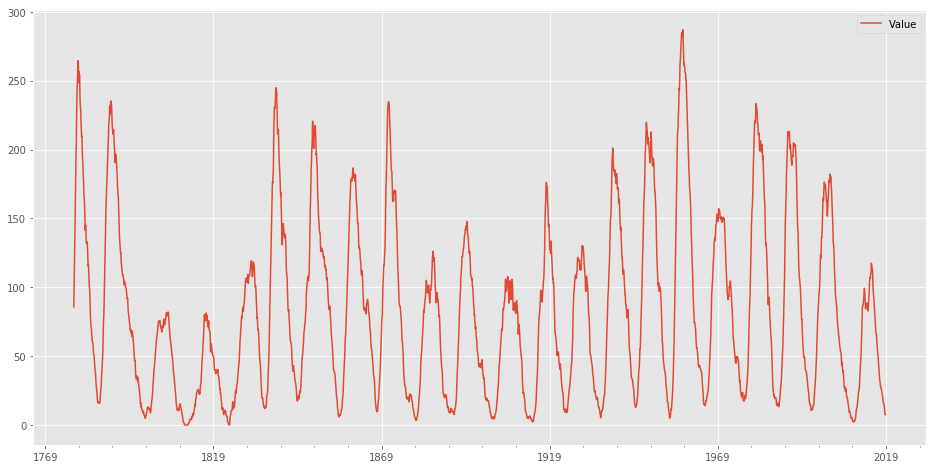

In [196]:
df = df[df.index >= pd.to_datetime(var_date)]
df.plot();

In [198]:
# convert an array of values into a dataset matrix
def create_dataset(df, look_back=1):
    y = df.iloc[look_back:].values
    tmp = df.values.flatten()
    x = np.array([tmp[i:i+look_back] for i in range(len(tmp) - look_back)])
    return x, y

np.random.seed(7)

train_size = int(len(df) * 0.70)
test_size = len(df) - train_size
train, test = df[:train_size], df[train_size:]

look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

model = Sequential()
model.add(Dense(12, input_dim=look_back, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=30, batch_size=2, verbose=2)

trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

Epoch 1/30
 - 1s - loss: 1631.9170
Epoch 2/30
 - 1s - loss: 59.8101
Epoch 3/30
 - 1s - loss: 20.1821
Epoch 4/30
 - 1s - loss: 16.8427
Epoch 5/30
 - 1s - loss: 15.5517
Epoch 6/30
 - 1s - loss: 14.8948
Epoch 7/30
 - 1s - loss: 13.9609
Epoch 8/30
 - 1s - loss: 13.7957
Epoch 9/30
 - 1s - loss: 14.1710
Epoch 10/30
 - 1s - loss: 13.7674
Epoch 11/30
 - 1s - loss: 12.7571
Epoch 12/30
 - 1s - loss: 12.2734
Epoch 13/30
 - 1s - loss: 12.5061
Epoch 14/30
 - 1s - loss: 11.6915
Epoch 15/30
 - 1s - loss: 10.9796
Epoch 16/30
 - 1s - loss: 11.5480
Epoch 17/30
 - 1s - loss: 11.6673
Epoch 18/30
 - 1s - loss: 12.2782
Epoch 19/30
 - 1s - loss: 11.4478
Epoch 20/30
 - 1s - loss: 11.4059
Epoch 21/30
 - 1s - loss: 10.0287
Epoch 22/30
 - 1s - loss: 12.9111
Epoch 23/30
 - 1s - loss: 9.8157
Epoch 24/30
 - 1s - loss: 10.3627
Epoch 25/30
 - 1s - loss: 11.2284
Epoch 26/30
 - 1s - loss: 10.6616
Epoch 27/30
 - 1s - loss: 10.5929
Epoch 28/30
 - 1s - loss: 11.8772
Epoch 29/30
 - 1s - loss: 10.4146
Epoch 30/30
 - 1s - lo

In [199]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

In [208]:
df['pred'] = np.concatenate([df[:look_back].values.flatten(), 
                            train_predict.flatten(),
                            df[train_size:train_size+look_back].values.flatten(),
                            test_predict.flatten()])

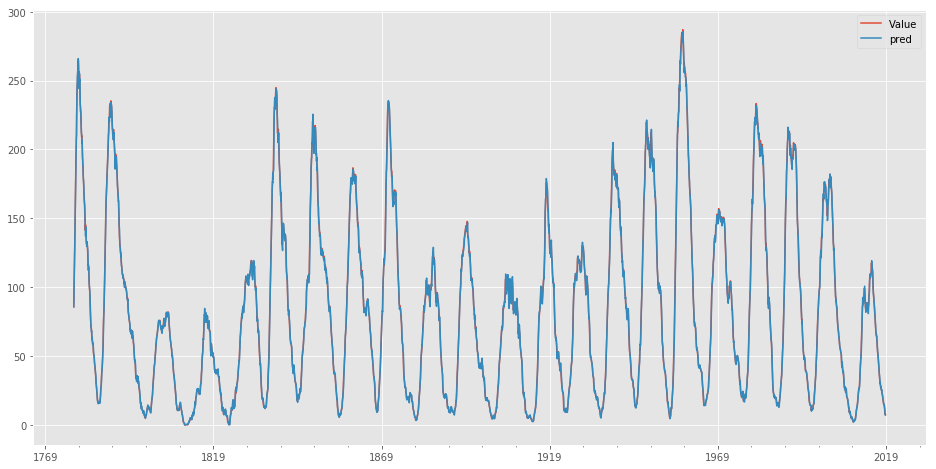

In [224]:
df.plot();

### Задание 2

In [228]:
def g(k):
    return np.sin(-3*k**2 + 10*k - 5)

def k_range(a, b, h):
    return np.linspace(a, b, int((b - a)/h))

p1 = np.sin(4*np.pi*k_range(0, 1, 0.025))
p2 = g(k_range(0.62, 3.14, 0.025))
t1 = [-1]*p1.size
t2 = [1]*p2.size
r = (0, 8, 6)

def repmat(p, r):
    return np.hstack([p for _ in range(r)]) if r else np.array([])

P = np.hstack([repmat(p1, r[0]), p2, repmat(p1, r[1]), p2, repmat(p1, r[2]), p2])
T = np.hstack([repmat(t1, r[0]), t2, repmat(t1, r[1]), t2, repmat(t1, r[2]), t2])

P_new = np.hstack([repmat(p1, 1), p2, repmat(p1, r[1]), p2, repmat(p1, r[2]), p2])
T_new = np.hstack([repmat(t1, 1), t2, repmat(t1, r[1]), t2, repmat(t1, r[2]), t2])

In [549]:
df2 = pd.DataFrame({'input' : P.flatten(), 'output' : T.flatten()})
df3 = pd.DataFrame({'input' : P_new.flatten(), 'output' : T_new.flatten()})

In [542]:
# convert an array of values into a dataset matrix
def create_dataset(df, look_back=1):
    y = df.output.iloc[look_back:].values
    tmp = df.input.values.flatten()
    x = np.array([tmp[i:i+look_back] for i in range(len(tmp) - look_back)])
    return x, y

np.random.seed(7)

train_size = int(len(df2) * 0.70)
test_size = len(df2) - train_size
train, test = df2[:train_size], df2[train_size:]

look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

model = Sequential()
model.add(Dense(12, input_dim=look_back, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=0)

trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

Train Score: 0.02 MSE (0.15 RMSE)
Test Score: 0.04 MSE (0.21 RMSE)


In [543]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

In [544]:
df2['pred'] = np.concatenate([df2.output[:look_back].values.flatten(), 
                              train_predict.flatten(),
                              df2.output[train_size:train_size+look_back].values.flatten(),
                              test_predict.flatten()])

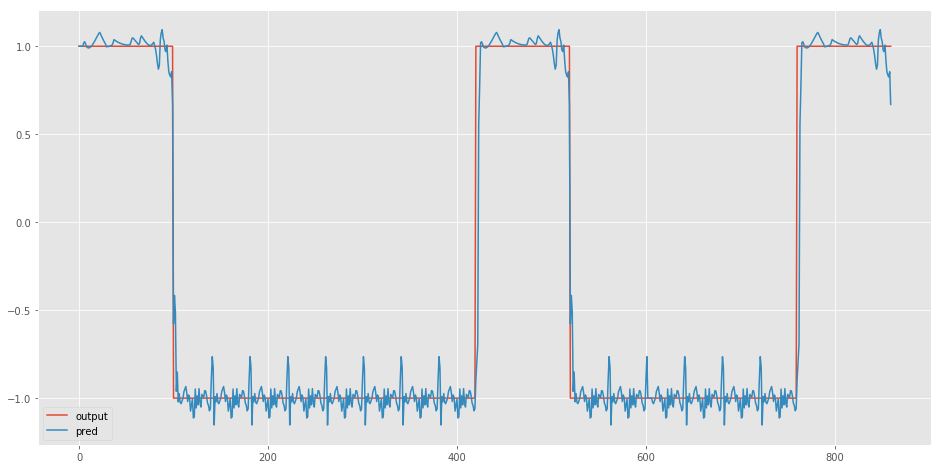

In [545]:
df2[['output', 'pred']].plot();

In [551]:
shift_x, shift_y = create_dataset(df3, look_back)

In [553]:
pred_shift = model.predict(shift_x)

In [556]:
df3['pred'] = np.concatenate([df3.output[:look_back].values.flatten(), 
                              pred_shift.flatten()])

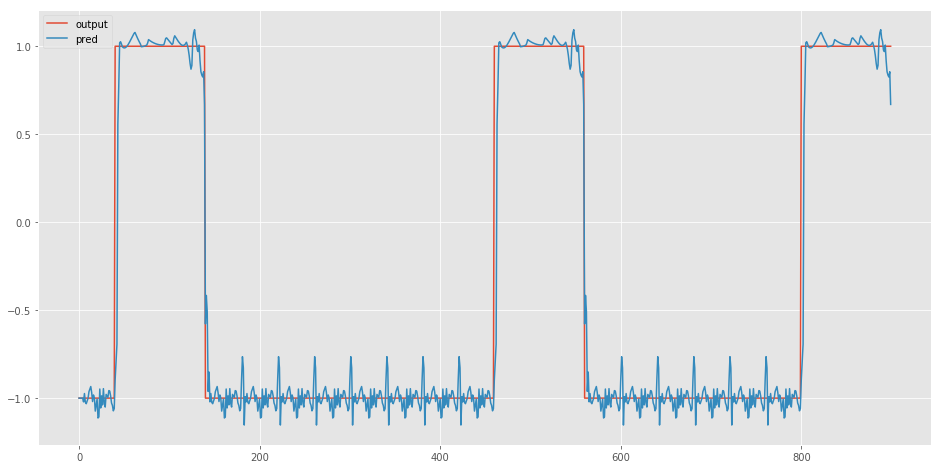

In [558]:
df3[['output', 'pred']].plot();

### Задание 3

In [484]:
def u(k):
    return np.sin(k**2)

h = 0.01
k_arr = np.linspace(0, 10, int(10/h), endpoint=True)
y = [0.0]
for k in k_arr:
    y.append(y[-1]/(1 + y[-1]**2) + u(k)**3)
y = np.array(y[:-1])

In [485]:
print('K shape', k_arr.shape)
print('Y shape', y.shape)

K shape (1000,)
Y shape (1000,)


In [486]:
train_size = int(y.shape[0]*0.8)
X_train = k_arr[:train_size]
X_test = k_arr[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

In [487]:
mdl = NARX(MLPRegressor(hidden_layer_sizes=(10, 10)), auto_order=2, exog_order=[2], exog_delay=[1])
mdl.fit(u(k_arr)[:, np.newaxis], y)
ypred = mdl.predict(u(k_arr)[:, np.newaxis], y, step=3)

In [488]:
ypred[np.isnan(ypred)] = 0

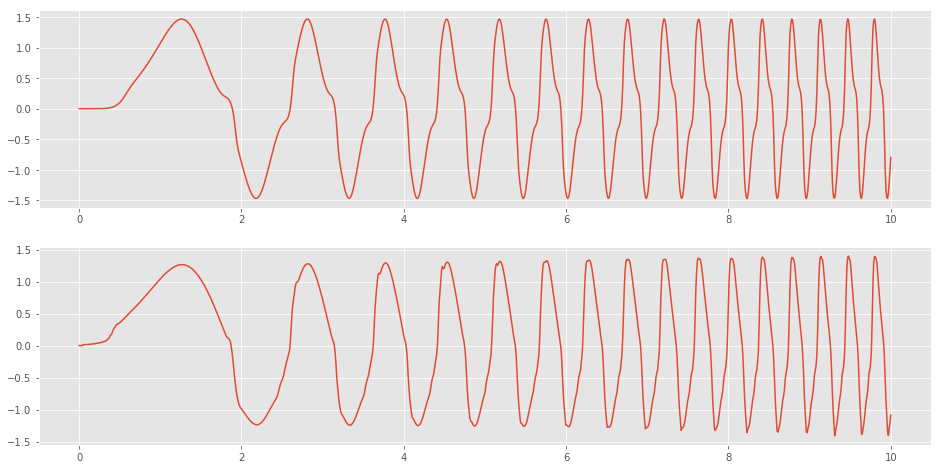

In [489]:
fit, ax = plt.subplots(2, 1)
ax[0].plot(k_arr, y);
ax[1].plot(k_arr, ypred);

In [480]:
mdl = NARX(MLPRegressor(hidden_layer_sizes=(10, 10)), auto_order=2, exog_order=[3], exog_delay=[3])
mdl.fit(u(X_train)[:, np.newaxis], y_train)
ypred = mdl.predict(u(X_test)[:, np.newaxis], y_test, step=1)

/Users/LeGatto53/anaconda3/envs/nn/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [481]:
delay_shift = 10

In [482]:
ypred[np.isnan(ypred)] = 0

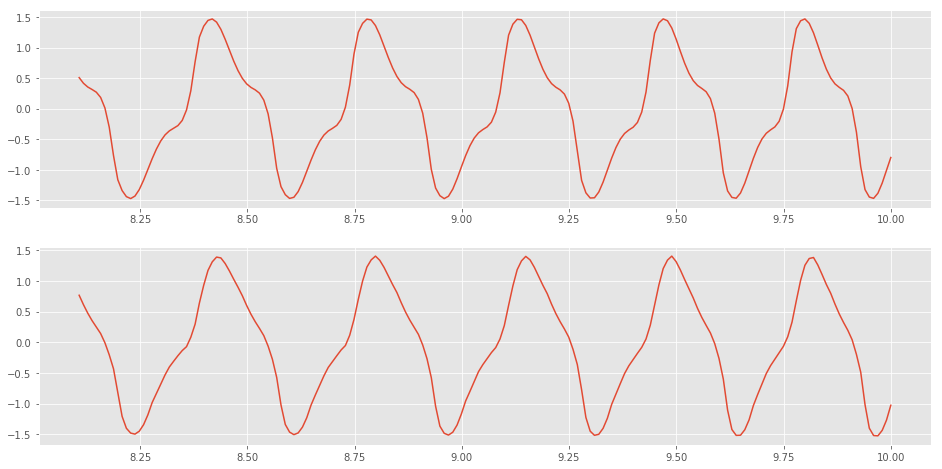

In [483]:
fit, ax = plt.subplots(2, 1)
ax[0].plot(X_test[delay_shift:], y_test[delay_shift:]);
ax[1].plot(X_test[delay_shift:], ypred[delay_shift:]);